# TTT4185 Machine learning for Speech technology

## Computer assigment 1: Speech analysis

This assignment assumes that the student has knowledge about short-time spectral estimation, linear prediction modeling and cepstral analysis. You should also know the concept of fundamental frequencies and formants.

Useful plotting commands from `matplotlib.pyplot`: `figure`, `plot`, `subplots`, `pcolormesh`

### Problem 1

In this problem we will look at a speech signal and do simple spectral analysis on the signal.

(a) Download the speech file `stry.wav` from Blackboard and load the file using `scipy.io.wavefile.read`. The speech represents the latter half of the English word "tapestry". The phonetic transcription is /s/ /t/ /r/ /iy/.
- Plot the signal.
- What is characteristic about the sounds /s/, /t/, /r/ and /iy/?
- Take a 40 millisecond subset of the vowel /iy/ and plot it.
- Find the fundamental frequency $f_0$ of the vowel.

16000


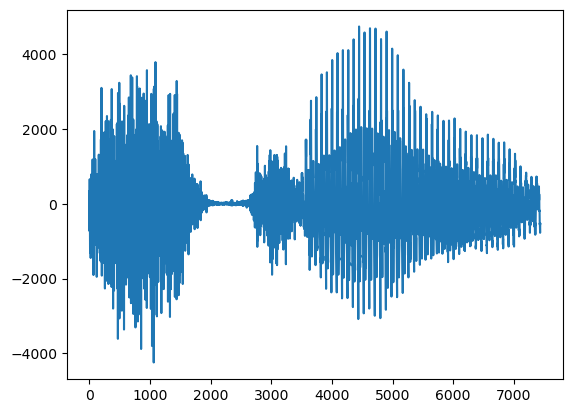

In [19]:
import scipy.io.wavfile
Fs, data = scipy.io.wavfile.read('stry(1).wav')

import matplotlib.pyplot as plt
import scipy as sp

print(Fs)

plt.plot(data)
plt.show()

The characteristics about the sound /s/ is that it is fairly long and has a large value.
The sound /t/ is short due to the plosive nature of the sound.
The /r/ is more rounded which gives it a larger value, and it is kind of added into the /iy/ sound.
The /iy/ is a vowel-like sound which slowly 'dies out'.

In [20]:
print(len(data))

7438


With a sampling frequency of 16kHz: 40ms -> 0.04*16000 = 640 samples

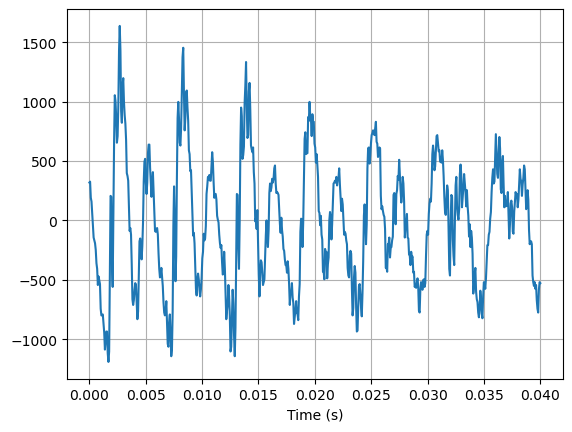

In [21]:
import numpy as np

t = np.linspace(0, 0.04, 640)

plt.plot(t, data[-640:])
plt.grid()
plt.xlabel("Time (s)")
plt.show()

The distance between two peaks, which is roughly the period, is approximately 75 samples.
This is equal to a frequency of 16000/75 = 213 Hz (sampling frequency/samples).
Thus f0 is approximately 213 Hz.

(b) Spectral analysis
- Estimate the spectrum of the vowel using an FFT of length 1024. Plot the spectrum expressed in dBs ($20 \log_10(x)$) as a function of frequency.
- Multiply the signal by a Hamming window and repeat the last operation.
- Explain the difference between the two spectra.
- Estimate the fundamental frequency $f_0$ using the spectrum, and compare the result to what you got in 1a)
- Roughly estimate the two first formant frequencies.

Useful Python functions: `numpy.fft.fft`, `numpy.abs`, `scipy.signal.hamming`.

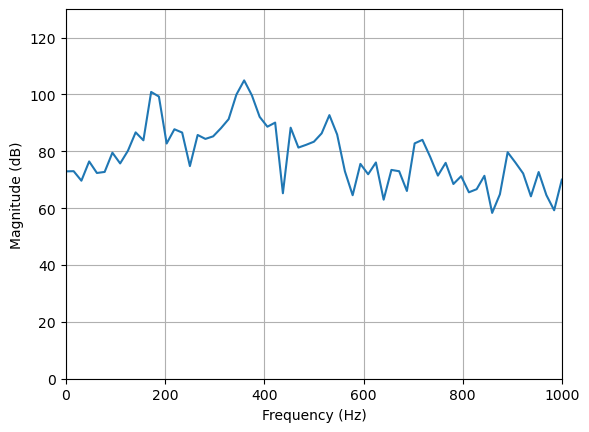

In [158]:
spectrum = np.fft.fft(data[-640:], 1024)
freq     = np.fft.fftfreq(1024, 1/Fs)
N        = len(spectrum)

plt.plot(freq[:N//2], 20*np.log10(np.abs(spectrum))[:N//2])
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim([0, 1000])
plt.ylim([0, 130])
plt.show()

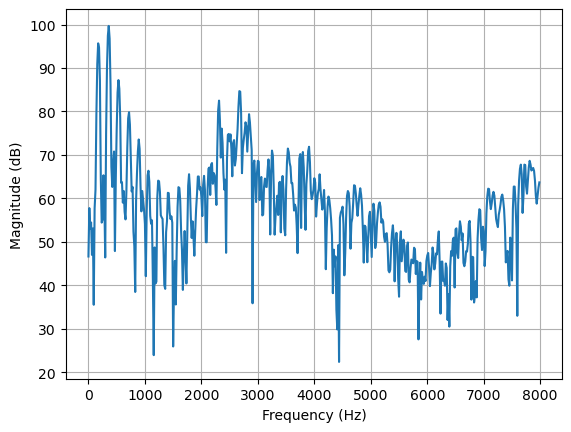

In [23]:
window       = sp.signal.windows.hamming(len(data[-640:]))
dataWindowed = data[-640:]*window

spectrumWindowed = np.fft.fft(dataWindowed, 1024)
freqWindowed     = np.fft.fftfreq(1024, 1/Fs)

plt.plot(freqWindowed[:N//2], 20*np.log10(np.abs(spectrumWindowed))[:N//2])
plt.grid()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.show()

By using a window such as Hanning, one reduces the magnitude of the side lobes in exchange for a wider main lobe.
The consequence of this when determining spesific frequencies such as formants in a speech signal is that it might be easier to see the general interval where the formants are, but it might be difficult to precise it more due to the additions of higher peaks surrounding the true formant. This masking of the frequencies is due to the wider main lobe.

The fundamental frequency is the frequency of the lowest peak in the spectrum. This can be estimated by: f0 ≈ frequency interval / amount of peaks in interval

f0 ≈ 1000/5 = 200 Hz

The deviation between this estimation and the earlier estimation is most likely due to the inaccuracy when interpreting the plots.

A rough estimate for the formants is: f1 = 300 Hz and f2 = 2500 Hz.

This estimate is found by 'looking for' the general shape of the formants from the spectrums.

(c) AR modeling
- Compute the coefficients of an AR model (linear prediction coefficients) with order 4, 8, 16 and 50, based on the vowel.
- Estimate the spectrum for each of the model orders. Plot the spectrum in dBs as a function of frequency.
- Compare your results with the spectrum from 1b). Which model order yields the "best" spectral envelope? What happens if the model order is too high or too low?
- Why is it not possible to estimate the fundamental frequency based on the LP model?

Useful Python functions: `pysptk.sptk.lpc`, `scipy.signal.freqz`. Check the documentation of the sptk package https://netix.dl.sourceforge.net/project/sp-tk to know which parameters are returned by the `lpc` function, and what model they correspond to.

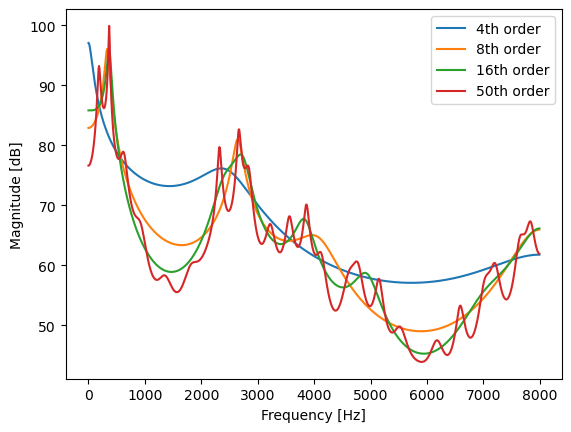

In [99]:
import pysptk

def getEstimate(order):
    # coefficients = pysptk.sptk.lpc(data[-640:], order)
    coefficients = pysptk.sptk.lpc(dataWindowed, order)
    poles = [1]
    for c in coefficients[1:]: poles.append(c)

    frequencies, estimatedSpectrum = sp.signal.freqz(b = coefficients[0], a = poles, worN = 1024, fs = Fs)
    return frequencies, estimatedSpectrum

f4,  eS4  = getEstimate(4)
f8,  eS8  = getEstimate(8)
f16, eS16 = getEstimate(16)
f50, eS50 = getEstimate(50)

plt.plot(f4,  20*np.log10(abs(eS4)))
plt.plot(f8,  20*np.log10(abs(eS8)))
plt.plot(f16, 20*np.log10(abs(eS16)))
plt.plot(f50, 20*np.log10(abs(eS50)))
plt.legend(["4th order", "8th order", "16th order", "50th order"])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.show()


The estimated spectrum is a lot cleaner, due to it being an estimation based on an AR-process and not a real sampled signal. Where as the previous spectrum had a lot of peaks closer to each other, the spectrum using LPC is smoother as mentioned with fewer peaks. This is due to there being a limitation on the amount of poles in the filter (order of the AR-process).

The problem with using LPC is the evaluation of optimal order for the filter. A too low order results in too few poles, underfitting. This gives a spectrum which does not include all the formants. An order that is too high results in overfitting, which in turn results in a spectrum that is difficult to interpret since it has too many peaks.

In our case, the 4th and 50th order results in under- and overfitting respectively. The 8th and 16th order filters are relatively alike, but the 16th might be the better spectrum.

Since the AR-process is using a limited amount of poles, the LPC filter does not model the source. Since the source is where the fundamental frequency is determined / generated, we are not able to determine this frequency using the LPC filter.

(d) Use `scipy.signal.spectrogram` to create a spectrogram of the entire speech signal. Try to generate both wide- and narrow-band spectrograms by adjusting the window lengths and overlaps. Which characteristic traits of the speech sounds /s/, /t/, /r/ and /iy/ can you see from the spectrogram?

In [141]:
def plotSpectrogram(windowLength, overlap = None):
    spectrogramWindow = sp.signal.windows.hamming(windowLength)
    f, t, Sdata = scipy.signal.spectrogram(data, fs = Fs, window = spectrogramWindow, noverlap = overlap)

    plt.figure(figsize=(4,2))
    plt.pcolormesh(t, f, Sdata, shading = "gouraud")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

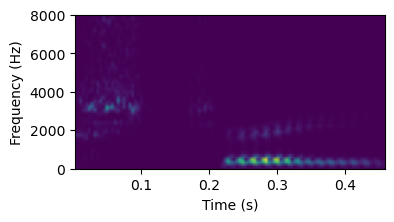

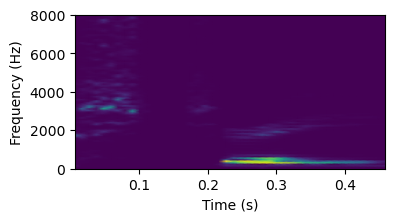

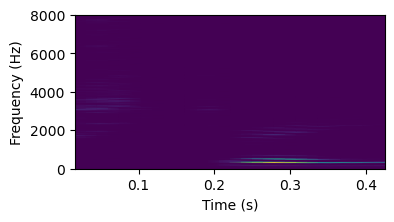

In [142]:
plotSpectrogram(100, 32)
plotSpectrogram(200, 32)
plotSpectrogram(500, 32)

Increasing the window length with a constant overlap reduces the time resolution but increases the frequency resolution, as expected.

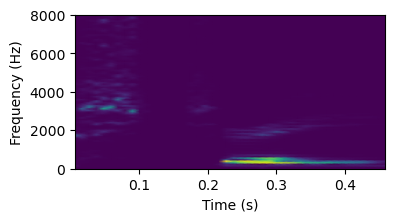

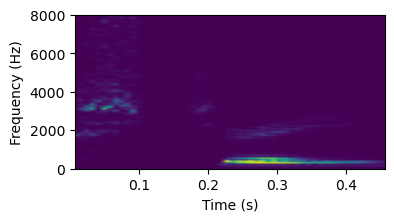

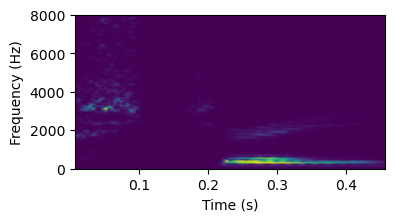

In [152]:
plotSpectrogram(200, 32)
plotSpectrogram(200, 64)
plotSpectrogram(200, 128)

Increasing the overlap but keeping the window length constant does not change the spectrum for the voiced speech much, but the spectrum for the voiceless fricative /s/ changes. The peaks in the spectrum becomes more prominent. The reasons for more prominent frequencies for the fricative /s/ when increasing the overlap might be due to the fricative being short in time. Thus, a larger overlap seems like an increase in the duration of the sound and thus giving a larger value where the peaks are.

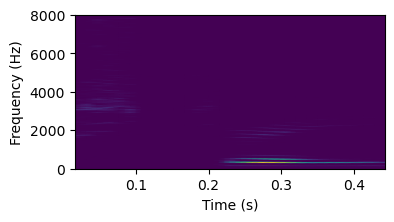

In [150]:
plotSpectrogram(500, 256)

Why is this?

### Problem 2
In this problem we look at the cepstrum and deconvolution

(a) Compute and plot the real cepstrum of the vowel from problem 1a).

(b) Use the cepstrum to compute the fundamental frequency $f_0$. Compare your results with those obtained in problem 1).

(c) In this subproblem you will use the cepstrum to estimate the spectral envelope
- Use liftering to extract the part of the ceptrum that represents the spectral envelope.
- Plot the spectral envelope as a function of frequency, and compare the result with the results from problem 1).

Hint 1: Remember that the cepstrum of a real signal is symmetric, so the liftered signal mus be symmetric as well.

Hint 2: The FFT of a real, symmtric signal is real, but due to round-off errors small imaginary noise may occur. Use `np.real` to get to the real part of the liftered log-spectrum.